In [1]:
using Revise, NeuralNetworkAnalysis, JLD2, Plots
const NNA = NeuralNetworkAnalysis

┌ Info: Precompiling NeuralNetworkAnalysis [73c0b437-a350-4e9b-97ac-9adb151c271b]
└ @ Base loading.jl:1260
┌ Warning: Replacing docs for `LazySets.HPolytope :: Union{Tuple{Union{Polyhedra.HRepresentation{N}, Polyhedra.Polyhedron{N}}}, Tuple{N}} where N` in module `LazySets`
└ @ Base.Docs docs/Docs.jl:229
┌ Warning: Replacing docs for `LazySets.HPolyhedron :: Union{Tuple{Union{Polyhedra.HRepresentation{N}, Polyhedra.Polyhedron{N}}}, Tuple{N}} where N` in module `LazySets`
└ @ Base.Docs docs/Docs.jl:229
┌ Warning: Replacing docs for `Polyhedra.polyhedron :: Union{Tuple{Union{HPolyhedron{N,VN} where VN<:AbstractArray{N,1}, HPolytope{N,VN} where VN<:AbstractArray{N,1}}}, Tuple{N}} where N<:Real` in module `LazySets`
└ @ Base.Docs docs/Docs.jl:229
┌ Warning: Replacing docs for `Polyhedra.polyhedron :: Union{Tuple{VPolytope{N,VN} where VN<:AbstractArray{N,1}}, Tuple{N}} where N<:Real` in module `LazySets`
└ @ Base.Docs docs/Docs.jl:229


NeuralNetworkAnalysis

In [2]:
controller = read_nnet("/home/sguadalupe/.julia/dev/NeuralNetworkAnalysis/models/Airplane/Airplane.nnet");

In [3]:
size(controller.layers[4].weights)

(6, 20)

In [20]:
@taylorize function ACC!(dx, x, p, t)
    _x, y, z, u, v, w, ϕ, θ, ψ, r, _p, q, Fx, Fy, Fz, Mx, My, Mz = x

    T_ψ = [cos(ψ)   -sin(ψ)   0.;
           sin(ψ)   cos(ψ)    0.;
           0.       0.        1.]

    T_θ = [cos(θ)   0.    sin(θ);
           0.       1.    0.;
           -sin(θ)  0.    cos(θ)]

    T_ϕ = [1.    0.      0.   ;
           0.  cos(ϕ)  -sin(ϕ);
           0.  sin(ϕ)   cos(ϕ)]

    mat_1 = T_ψ * T_θ * T_ϕ

    mat_2 = [cos(θ)  sin(θ) * sin(ϕ)       sin(θ) * cos(ϕ);
             0.          cos(θ) * cos(ϕ)  -cos(θ) * sin(ϕ);
             0.          sin(ϕ)               cos(ϕ)     ]
    mat_2 = 1 / cos(θ) * mat_2

    a1 = [u; v; w]
    a2 = mat_1 * a1

    _dx = a2[1]
    dy = a2[2]
    dz = a2[3]

    a3 = [_p; q; r]
    a4 = mat_2 * a3

    dϕ = a4[1]
    dθ = a4[2]
    dψ = a4[3]

    du = -sin(θ)          + Fx - q * w + r * v
    dv =  cos(θ) * sin(ϕ) + Fy - r * u + _p * w
    dw =  cos(θ) * cos(ϕ) + Fz - _p * v + q * u

    dp = Mx
    dq = My
    dr = Mz

    dx[1] = _dx
    dx[2] = dy
    dx[3] = dz
    dx[4] = du
    dx[5] = dv
    dx[6] = dw
    dx[7] = dϕ
    dx[8] = dθ
    dx[9] = dψ
    dx[10] = dp
    dx[11] = dq
    dx[12] = dr
    dx[13] = zero(Fx)
    dx[14] = zero(Fy)
    dx[15] = zero(Fz)
    dx[16] = zero(Mx)
    dx[17] = zero(My)
    dx[18] = zero(Mz)
end

In [21]:
X₀ = Hyperrectangle(low=[0., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], high=[0., 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]);
U₀ = Universe(6)
prob = @ivp(x' = ACC!(x), dim: 18, x(0) ∈ X₀ × overapproximate(U₀, Hyperrectangle));
vars_idx = Dict(:state_vars=>1:12, :input_vars=>[], :control_vars=>13:18);

In [25]:
plant = ControlledPlant(prob, controller, vars_idx);
alg = TMJets(abs_tol=1e-9, orderT=8, orderQ=1)
solver = Ai2z()
@time sol = solve(plant, T=0.2, Tsample=0.1, alg_nn=solver, alg=alg)
solz = overapproximate(sol, Zonotope);

 91.290795 seconds (837.69 M allocations: 64.135 GiB, 17.78% gc time)


┌ Warning: Minimum absolute tolerance, 1.0e-29 reached.
└ @ ReachabilityAnalysis /home/sguadalupe/.julia/dev/ReachabilityAnalysis/src/Algorithms/TMJets/post.jl:56


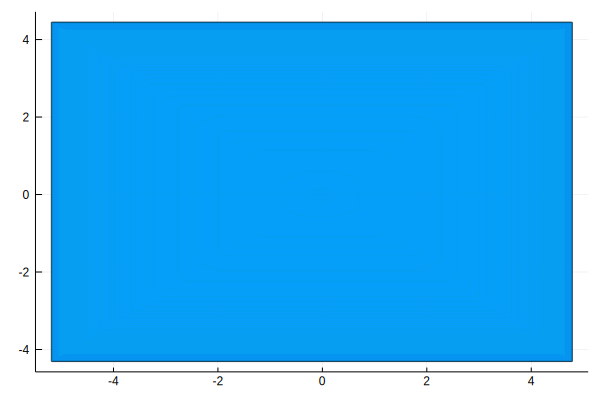

In [29]:
plot(solz, vars=(1, 2), alpha=0.1)